# K-Nearest Neighbor model

In [3]:
# Set the seed value for the notebook so the results are reproducible
from numpy.random import seed
seed(42)

# Imports
import numpy as np
import pandas as pd
import joblib

import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', DeprecationWarning )
%matplotlib inline
import matplotlib.pyplot as plt

#from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


## 1. Read the data

In [4]:
# read the X_train X_test, y_train, y_test data
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

## 2. Scale the data

In [5]:
# Use MinMaxScaler
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## 3. Encode the labels

In [6]:
# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_encoded = label_encoder.transform(y_train)
label_encoder.fit(y_test)
y_test_encoded = label_encoder.transform(y_test)
# Step 2: 
from keras.utils import to_categorical

# Step 2: One-hot encoding
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

//anaconda3/envs/PythonWebMongo/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda3/envs/PythonWebMongo/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Using TensorFlow backend.


## 4. Setup the KNN Model

k: 1, Train/Test Score: 1.000/0.703
k: 3, Train/Test Score: 0.932/0.811
k: 5, Train/Test Score: 0.905/0.824
k: 7, Train/Test Score: 0.914/0.797
k: 9, Train/Test Score: 0.887/0.797
k: 11, Train/Test Score: 0.865/0.797
k: 13, Train/Test Score: 0.860/0.797
k: 15, Train/Test Score: 0.865/0.797
k: 17, Train/Test Score: 0.865/0.797
k: 19, Train/Test Score: 0.847/0.811


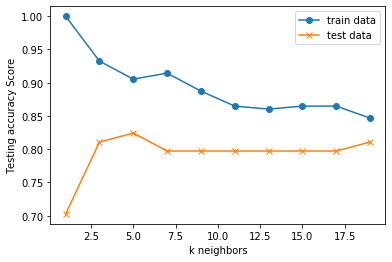

In [11]:
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 21, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_one_hot)
    train_score = knn.score(X_train_scaled, y_train_one_hot)
    test_score = knn.score(X_test_scaled, y_test_one_hot)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 21, 2), train_scores, marker='o', label='train data')
plt.plot(range(1, 21, 2), test_scores, marker='x', label = 'test data')
plt.legend(loc = 'upper right')
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.savefig('knn_train_test_accuracy.png')
plt.show()

## 5. Check the accuracy of the Model

In [8]:
# Note that k: 5 seems to be the best choice for this dataset
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train_scaled, y_train_one_hot)
print('k=5 Test Acc: %.3f' % knn.score(X_test_scaled, y_test_one_hot))

k=5 Test Acc: 0.784


## 6. Tune the mode

//anaconda3/envs/PythonWebMongo/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


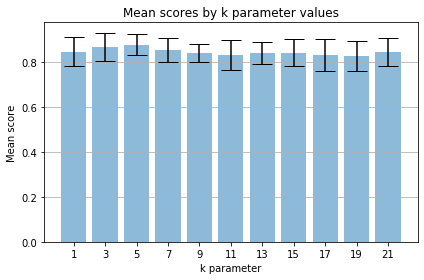

In [9]:
#Tune the KNN model
num_folds=10
seed=42
scoring =  'accuracy'
neighbors = [1,3,5,7,9,11,13,15,17,19,21]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
model = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = model.fit(X_train_scaled, y_train_one_hot)
# print(f'Best score : {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
params

knn_results = pd.DataFrame (list(zip(means, stds, neighbors)), columns=['means', 'stds', 'k'])

# Plot the means and stds across the k values

x_pos = np.arange(len(neighbors))
fig, ax = plt.subplots()
ax.bar(x_pos, knn_results['means'],
       yerr=knn_results['stds'],
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Mean score')
ax.set_xlabel('k parameter')
ax.set_xticks(x_pos)
ax.set_xticklabels(neighbors)
ax.set_title('Mean scores by k parameter values')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('mean_scores.png')
plt.show()

## 7. Make Predictions

In [8]:
# Make predictions using X_test_scaled
encoded_predictions = model.predict(X_test_scaled)

In [9]:
# Decode the data

# Define a decode function
def decode(datum):
    return np.argmax(datum)

labeled_predictions =[]
for i in range(encoded_predictions.shape[0]):
    datum = encoded_predictions[i]
    #print(f'index: {i}')
    #print(f'encoded datum: {datum}')
    decoded_datum = decode(encoded_predictions[i])
    if (decoded_datum ==0):
        prediction='buff'
    else: 
        prediction= 'sick'
    # print(f'decoded datum: {decoded_datum}')
    print(f' index {i} predicted label: {prediction}')
    actual = y_test['buff'][i] 
    labeled_predictions.append(prediction)
    
    if (prediction != actual):
        print (f'*** missmatch **** index: {i} Predited = {prediction}  Actual = {actual}')


 index 0 predicted label: sick
 index 1 predicted label: sick
 index 2 predicted label: sick
 index 3 predicted label: buff
 index 4 predicted label: buff
*** missmatch **** index: 4 Predited = buff  Actual = sick
 index 5 predicted label: buff
 index 6 predicted label: buff
 index 7 predicted label: buff
*** missmatch **** index: 7 Predited = buff  Actual = sick
 index 8 predicted label: buff
 index 9 predicted label: sick
 index 10 predicted label: buff
 index 11 predicted label: buff
 index 12 predicted label: sick
 index 13 predicted label: buff
 index 14 predicted label: sick
 index 15 predicted label: buff
 index 16 predicted label: buff
 index 17 predicted label: sick
*** missmatch **** index: 17 Predited = sick  Actual = buff
 index 18 predicted label: sick
 index 19 predicted label: buff
 index 20 predicted label: buff
 index 21 predicted label: sick
 index 22 predicted label: sick
 index 23 predicted label: buff
 index 24 predicted label: sick
 index 25 predicted label: sick


## 8. Save the model

In [56]:
filename = 'KNN.sav'
joblib.dump(model, filename)

['KNN.sav']

In [57]:
KNN = joblib.load('KNN.sav')